# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install fastdownload -qq
    !pip install fastai -U -qq
    !pip install fastcore -U -qq
    !pip install kaggle -U -qq
    !pip install torchinfo -qq
else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Mounted at /content/drive


In [3]:
base_folder

PosixPath('/content/drive/MyDrive')

In [4]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023/'
sys.path.append(str(custom_function_folder))
kaggle_api_folder=base_folder/'data/.kaggle'
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed'
model_folder.mkdir(parents=True, exist_ok=True)

# <Font color = 'indianred'>**Import Libraries**

In [7]:
import os
import numpy as np
from fastdownload import FastDownload
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms
from data_loaders_dog_breed import get_loaders
from shared_utils import check_loader, check_transforms, plot_history
from model_two_layer import TwoLayerMLP
from train_functions import train, get_pred
from datetime import datetime


# <Font color = 'indianred'>**Setup Kaggle API**

In [8]:
# Set the environment variable 'KAGGLE_CONFIG_DIR' to the path of '.kaggle' folder for Kaggle API authentication
os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_api_folder)

In [9]:
!ls -la {str(kaggle_api_folder/'kaggle.json')}

-rw------- 1 root root 62 Sep 17 13:08 /content/drive/MyDrive/data/.kaggle/kaggle.json


In [10]:
# Import the Kaggle API client to interact with Kaggle datasets and competitions
from kaggle import api

# <Font color = 'indianred'>**Download file from Kaggle Competition**

In [11]:
# Download the 'dog-breed-identification' competition dataset from Kaggle and save it in the 'archive' folder within 'base_folder'
!kaggle competitions download -c dog-breed-identification -p {data_folder/'archive'}

100% 691M/691M [00:34<00:00, 21.5MB/s]
100% 691M/691M [00:34<00:00, 21.1MB/s]


In [12]:
d = FastDownload(base=data_folder, archive='archive', data='datasets')

In [13]:
image_files_path = d.extract(data_folder/'archive/dog-breed-identification.zip')

In [14]:
image_files_path

Path('/content/datasets/dog-breed-identification')

# <Font color = 'indianred'>**Get dataloaders**

In [15]:
400*375/500

300.0

In [16]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            # Resize the shorter side of the image to (500, 375) pixels
            transforms.Resize((500, 375)),
            # Perform a random crop to obtain a 267x200 image
            # transforms.RandomCrop((400, 300)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            # Resize the shorter side of the image to 640 pixels
            transforms.Resize((500, 375)),
            # Perform a center crop to obtain a 427x427 image
            # transforms.CenterCrop((400, 300)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [17]:
train_loader, val_loader, test_loader = get_loaders(img_folder=image_files_path,
                                                    csv_file=image_files_path/'labels.csv',
                                                    train_transform=data_transforms['train'],
                                                    test_transform=data_transforms['test'],
                                                    fraction_train=0.8,
                                                    seed=42,
                                                    batch_size = 256,
                                                    small_subset= True,
                                                    num_samples_small=1000)

In [18]:
check_loader(train_loader)

 Batch Number: 1 | Batch size: 256 | x shape: torch.Size([256, 3, 500, 375]) | y shape: torch.Size([256])
 Batch Number: 2 | Batch size: 256 | x shape: torch.Size([256, 3, 500, 375]) | y shape: torch.Size([256])
 Batch Number: 3 | Batch size: 256 | x shape: torch.Size([256, 3, 500, 375]) | y shape: torch.Size([256])

Labels from current batch 
 tensor([ 90,  25,  13,  89,   2,  31, 102, 113,  68,  68,  53,  36,   6, 102,
         53,  43,  79,  72,  51,  50,   5,   3,  97,  44,  82,  60,   0,  23,
         42,  25,  89,  77,  17,  90,   1, 104,  63,  60,  51,  64, 115,  26,
         94,  39,  64,  67,  50,  10,  76, 101,  33,  80,  93,  12,  56, 106,
         20,  22, 104,  68,  35,  64,  93, 103,  20,  75,  32, 112,  59,  12,
         84,  12,   2,  69,  16,  62,  77, 117,   5,  94,  41, 116,  27,  54,
         31,  47,  33,  70,  79, 105, 111,  87,  92,  60,  82, 106,  86,  69,
         78,  66,  79,  19,  42,   5,  57,  70,  13,  52,  52,  31,  99,  33,
         14,  29,  98, 111,  

In [19]:
check_transforms(train_loader)

shape of inputs is :torch.Size([256, 3, 500, 375])

max input value  :1.0

min input value  :-1.0

mean input value  :-0.11666394770145416

std input value  :0.531529426574707

shape of targets is :torch.Size([256])

inputs  :tensor([[0.2157, 0.2784, 0.3020, 0.2784, 0.2078],
        [0.1686, 0.2235, 0.2549, 0.2392, 0.1765],
        [0.1294, 0.1843, 0.2235, 0.2235, 0.1686],
        [0.1059, 0.1373, 0.1843, 0.2000, 0.1451],
        [0.0745, 0.0824, 0.1216, 0.1373, 0.0745]])


In [20]:
len(train_loader)

4

# <Font color = 'indianred'>**Train Model**

In [21]:
# Define the model architecture and training parameters
num_features = 3*375*500
hidden_dim1 = 500
hidden_dim2 = 500
num_classes = 120
epochs = 5
learning_rate = 0.1


# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

# Define the optimizer for updating model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function for training
loss_function = nn.CrossEntropyLoss()

# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 3, 500, 375))

Layer (type:depth-idx)                   Output Shape              Param #
TwoLayerMLP                              [1, 120]                  --
├─Sequential: 1-1                        [1, 120]                  --
│    └─Flatten: 2-1                      [1, 562500]               --
│    └─Linear: 2-2                       [1, 500]                  281,250,500
│    └─ReLU: 2-3                         [1, 500]                  --
│    └─Linear: 2-4                       [1, 500]                  250,500
│    └─ReLU: 2-5                         [1, 500]                  --
│    └─Linear: 2-6                       [1, 120]                  60,120
Total params: 281,561,120
Trainable params: 281,561,120
Non-trainable params: 0
Total mult-adds (M): 281.56
Input size (MB): 2.25
Forward/backward pass size (MB): 0.01
Params size (MB): 1126.24
Estimated Total Size (MB): 1128.50

In [22]:
# Sanity check to verify initial loss
i = 0
expected_loss = np.log(120)  # Theoretical loss for a random model
for input_, targets in train_loader:
    # Move inputs and targets to the specified device
    input_ = input_.to(device)
    targets = targets.to(device)
    model.to(device)
    model.eval()

    # Forward pass
    output = model(input_)

    # Calculate the loss
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')

    i += 1
    if i > 1:
        break

print(f'Expected Theoretical loss: {expected_loss}')


Actual loss: 4.788822650909424
Actual loss: 4.797169208526611
Expected Theoretical loss: 4.787491742782046


In [23]:
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, val_loader, model, optimizer, loss_function, epochs, device
)

Epoch 1/5
Train Loss: 4.8489 | Train Accuracy: 0.80%
Valid Loss: 4.8500 | Valid Accuracy: 1.91%

Epoch 2/5
Train Loss: 4.4045 | Train Accuracy: 7.50%
Valid Loss: 4.9531 | Valid Accuracy: 1.51%

Epoch 3/5
Train Loss: 4.0175 | Train Accuracy: 17.20%
Valid Loss: 4.9875 | Valid Accuracy: 2.62%

Epoch 4/5
Train Loss: 3.5626 | Train Accuracy: 26.70%
Valid Loss: 5.1545 | Valid Accuracy: 3.02%

Epoch 5/5
Train Loss: 2.9503 | Train Accuracy: 37.50%
Valid Loss: 5.6665 | Valid Accuracy: 2.11%



# <Font color = 'indianred'>**Plot Losses**

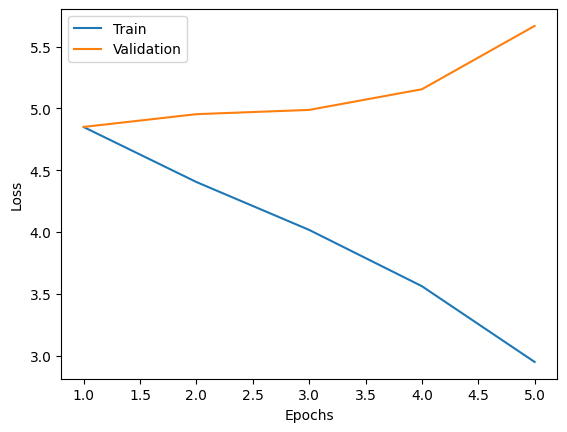

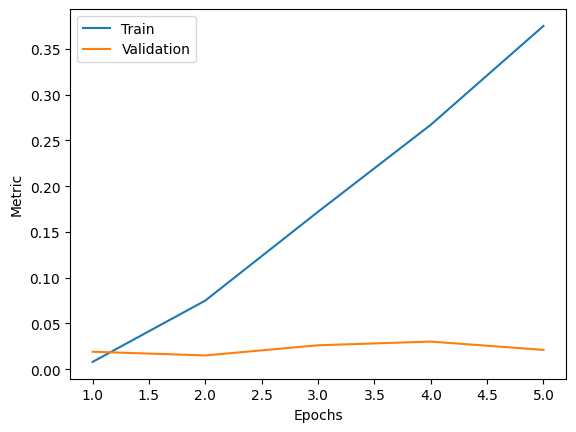

In [24]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# <Font color = 'indianred'>**Checkpointing**

In [25]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer_skip'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

Path('/content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/2023-09-25_20-55-17_twolayer_skip.pt')

In [26]:
# Save the model's state dictionary to the specified file path
torch.save(model.state_dict(), path)

# <Font color = 'indianred'>**Predictions**

In [27]:
# Create an instance of the model with the same architecture
my_model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [28]:
# Get the prediction and accuracy
predictions_test = get_pred(test_loader, my_model, device)

In [29]:
predictions_test[0:5]

tensor([54., 54., 64., 36., 26.], device='cuda:0')